In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats


In [9]:
# Read data
names = ['userid', 'itemid', 'rating', 'timestamp']
raw_data = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)

# save data in a numpy array where each user ratings have their own rows
userids = sorted(list(raw_data['userid'].unique()))
itemids = sorted(list(raw_data['itemid'].unique()))

# first save in list of lists, use None values if user has not rated item
data = [[None] * len(itemids) for x in range(len(userids))]

# find ratings made by each user
for i in range(len(userids)):
    # dict of ratings for user i+1 (key = itemid, value = rating)
    user_ratings = dict(zip(raw_data.loc[raw_data['userid'] == (i+1)].itemid, raw_data.loc[raw_data['userid'] == (i+1)].rating))
    for j in range(len(itemids)):
        # check if user has rated item with id j+1
        if j+1 in user_ratings:
            data[i][j] = user_ratings[j+1]

data = np.array(data)

User-based colloborative filterin approach from Assignment 1

In [4]:
# a, b = userids, data = whole data set
def similarity(a,b, data):
    data_a = data[a-1] # remember that indexing starts from 0, but userids from 1
    data_b = data[b-1]

    # dicts with itemids and ratings
    dict_a = {i: r for i, r in enumerate(data_a, start=1) if r is not None}
    dict_b = {i: r for i, r in enumerate(data_b, start=1) if r is not None}

    # intersections of common itemids
    P = list(set(dict_a).intersection(set(dict_b)))

    if len(P) < 2:
        return 0

    # keep only common itemids
    dict_a = {id: dict_a[id] for id in P}
    dict_b = {id: dict_b[id] for id in P}

    # Create constants
    const_a = list(dict_a.values())
    const_b = list(dict_b.values())

    sim, p = stats.pearsonr(const_a, const_b)

    # Check for NaN
    if sim != sim:
        return 0
    return sim

# Similarity matrix
N = 0
sim_matrix = [[1] * len(userids) for x in range(len(userids))]
for i in range(len(userids)):
    for j in range(i+1, len(userids)):
        sim_matrix[i][j] = sim_matrix[j][i] = similarity(i+1, j+1, data)

sim_matrix = np.array(sim_matrix)

# a = userid, p = itemid, data = whole data set, 
# sim = similarity matrix t = similarity threshold
def predict(a, p, data, sim_matrix, t):
    sim = sim_matrix[a-1]
    # mean of ratings given by user a
    mean_a = np.mean([r for r in data[a-1] if r is not None])

    # transform similarities to dict (key = userid, value = similarity) and filter out unvanted similarities
    sim = {i: s for i, s in enumerate(sim, start=1) if s >= t}

    n = 0
    d = 0

    for b in sim:
        # chekc if user b has not rated the item
        if data[b-1][p-1] == None:
            continue

        mean_b = np.mean([r for r in data[b-1] if r is not None])
        n += sim[b] * (data[b-1][p-1] - mean_b)
        d += sim[b]

    if n == 0:
        return mean_a

    return mean_a + n/d

B:\Anaconda\envs\recommender\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
# g = groud of users (list of usedids), i = itemid, data = whole dataset
def average_aggregation(g, i, data):
    # ratings for item i, given by users in the group
    ratings = []

    # obtaing ratings, either from data or predict it
    for user in g:
        rating = data[user-1][i-1]
        if rating == None:
            rating = predict(user, i, data, sim_matrix, 10)
        ratings.append(rating)
    
    return np.average(ratings)

In [6]:
def least_misery_aggregation(g, i, data):
    # ratings for item i, given by users in the group
    ratings = []

    # obtaing ratings, either from data or predict it
    for user in g:
        rating = data[user-1][i-1]
        if rating == None:
            rating = predict(user, i, data, sim_matrix, 10)
        ratings.append(rating)
    
    return np.min(ratings)

In [21]:
def groupListSat(data, grouplist, user):
        sat = 0

        for item in grouplist:
            score = data[user-1][item-1]
            if score == None:
                score = predict(user, item, data, sim_matrix, 10)
            sat += score

        return sat

In [71]:
def userListSat(data, user, n):
    predictions = {}

    for item in itemids:
        score = data[user-1][item-1]
        if score == None:
            score = predict(user, item, data, sim_matrix, 0.0)
        predictions[item] = score

    # sort predictions and take 20 highest
    most_relevant = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True))
    most_relevant = dict(list(most_relevant.items())[:n])
    
    return sum(most_relevant.values())

# makes thing go fast prrr
g = [1, 2, 3]  
userListSatCache = {}
for user in g:
    userListSatCache[user] = userListSat(data, user, 20)

Iteration: 1
    itemid    rating
0       50  4.265432
1      100  4.265432
2      127  4.265432
3      242  4.265432
4      181  4.236559
5      320  4.106657
6      321  4.106657
7      328  4.106657
8      340  4.106657
9      346  4.106657
10     347  4.106657
11       1  3.932099
12      13  3.932099
13      14  3.932099
14     111  3.932099
15     251  3.932099
16     269  3.932099
17     268  3.903226
18       6  3.835325
19       9  3.835325
Iteration: 2
    itemid    rating
0      320  4.238591
1      321  4.238591
2      328  4.238591
3      340  4.238591
4      346  4.238591
5      347  4.238591
6      181  4.201623
7       50  4.048461
8      100  4.048461
9      127  4.048461
10     242  4.048461
11     318  3.806801
12     327  3.806801
13     329  3.806801
14     331  3.806801
15     342  3.806801
16     344  3.806801
17     348  3.806801
18     268  3.769832
19       1  3.764357
Iteration: 3
    itemid    rating
0       50  4.351076
1      100  4.351076
2      127  4.35

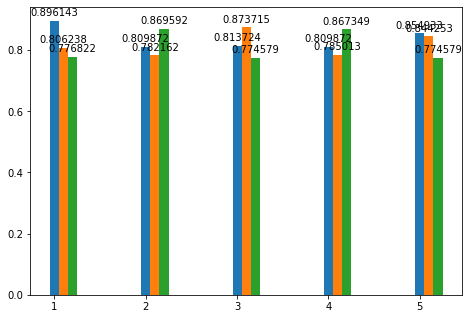

In [96]:
# data = whole dataset, g = group, mu = number of iterations
def sequential_recommendations(data, g, mu, n):
    satisfactions_mu = []
    alpha = 0
    least_satisfied = 0
    
    for m in range(mu):
        satisfactions = []

        # group recommendations
        scores = {}

        for i in itemids:
            avg_score = average_aggregation(g, i, data)

            leastScore = data[least_satisfied-1][i-1]
            if leastScore == None:
                leastScore = predict(least_satisfied, i, data, sim_matrix, 10)
                 
            scores[i] = (1-alpha)*avg_score + alpha*leastScore
            
        # sort scores and take recommendations 
        scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
        
        recommendations = dict(list(scores.items())[:n])
        
        for user in g:
            satisfactions.append(groupListSat(data, recommendations, user) / userListSatCache[user])
            
        # least satisfied user during this iteration    
        least_satisfied = g[satisfactions.index(min(satisfactions))]
        
        # original alpha calculation
        #alpha = max(satisfactions) - min(satisfactions)
        alpha = 0
        for s in satisfactions:
            alpha += (max(satisfactions)-s) ** (2/3)
        #alpha = (max(satisfactions) - min(satisfactions))**(2/3)
        alpha = alpha / len(satisfactions)
        satisfactions_mu.append(satisfactions)
        
        # print recommendations
        df = pd.DataFrame(list(zip(list(recommendations.keys()), list(recommendations.values()))), columns=['itemid', 'rating'])
        print('Iteration:', m+1)
        print(df)

    # plot satisfactions
    fig = plt.figure()
    X = np.arange(1,mu+1)
    satisfactions_mu = np.transpose(np.array(satisfactions_mu))

    ax = fig.add_axes([0,0,1,1])
    shift = 0
    for sat in satisfactions_mu:
        bar = ax.bar(X + shift, sat, width = 0.1) 
        shift += 0.1
        ax.bar_label(bar, padding=3)
        
sequential_recommendations(data, g, 5, 20)     